### Image Denoising using keras

In [3]:
from keras.datasets import mnist 
import numpy as np
import matplotlib.pyplot as plt

In [98]:
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float') / 255
x_test = x_test.astype('float') / 255

x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

In [99]:
noisy_factor = 0.5
x_train_noisy  = x_train + noisy_factor * np.random.normal(0, 1, size=x_train.shape)
x_test_noisy  = x_test + noisy_factor * np.random.normal(0, 1, size=x_test.shape)

## clip the noisy images between 0 and 1
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

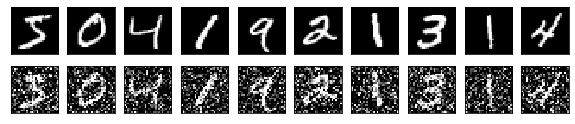

In [101]:
plt.figure(figsize=(10,2))
for i in range(10):
    ax = plt.subplot(2, 10, i+1)
    plt.imshow(x_train[i].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(2, 10, i+1+10)
    plt.imshow(x_train_noisy[i].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

### Auto encoder

In [102]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPool2D, UpSampling2D


### Encoder
input_img = Input(shape=(28, 28, 1))
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPool2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3),activation='relu', padding='same')(x)
encoded = MaxPool2D((2, 2))(x)

## decoder
x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3,3), padding='same')(x)

autoencoder = Model(input_img, decoded)

In [103]:
autoencoder.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 7, 7, 32)          9248      
_________________________________________________________________
up_sampling2d_9 (UpSampling2 (None, 14, 14, 32)        0   

In [104]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [72]:
hist = autoencoder.fit(x_train_noisy, x_train, batch_size=128, epochs=10,
                       shuffle=True, validation_data=(x_test_noisy, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 105s 2ms/step - loss: 0.1980 - val_loss: 0.1712
Epoch 2/10
60000/60000 [==============================] - 109s 2ms/step - loss: 0.1645 - val_loss: 0.1448
Epoch 3/10
60000/60000 [==============================] - 111s 2ms/step - loss: 0.1604 - val_loss: 0.1421
Epoch 4/10
60000/60000 [==============================] - 120s 2ms/step - loss: 0.1415 - val_loss: 0.1352
Epoch 5/10
60000/60000 [==============================] - 118s 2ms/step - loss: 0.1429 - val_loss: 0.1399
Epoch 6/10
60000/60000 [==============================] - 115s 2ms/step - loss: 0.1425 - val_loss: 0.1325
Epoch 7/10
60000/60000 [==============================] - 112s 2ms/step - loss: 0.1495 - val_loss: 0.1561
Epoch 8/10
60000/60000 [==============================] - 107s 2ms/step - loss: 0.1376 - val_loss: 0.1322
Epoch 9/10
60000/60000 [==============================] - 107s 2ms/step - loss: 0.1400 - val_loss: 0.1

#### Validate the results

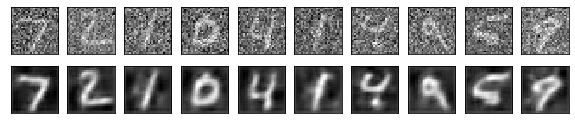

In [96]:
predictions = autoencoder.predict(x_test_noisy)
plt.figure(figsize=(10, 2))
for i in range(10):
    ax = plt.subplot(2, 10, i+1)
    ax.imshow(x_test_noisy[i].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(2, 10, i+1+10)
    ax.imshow(predictions[i].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

###  Image Denoising using Pytorch

In [123]:
from torchvision import datasets, transforms
import torch
import torch.nn as nn
import torch.nn.functional as F

In [124]:
transform = transforms.ToTensor()

train_set = datasets.MNIST(root='./data', train=True, transform = transform)
test_set = datasets.MNIST(root='./data', train=False, transform = transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=20)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=20)

In [154]:
class Denoiser(nn.Module):
    def __init__(self):
        super(Denoiser, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        
        self.conv2 = nn.Conv2d(32, 16, 3, padding=1)
        
        self.conv3 = nn.Conv2d(16, 8, 3, padding=1)
        
        self.pool = nn.MaxPool2d((2, 2))
        
        self.tconv1 = nn.ConvTranspose2d(8, 8, 3, stride=2)
        
        self.tconv2 = nn.ConvTranspose2d(8, 16, 2, stride=2)
        
        self.tconv3 = nn.ConvTranspose2d(16, 32, 2, stride=2)
        
        self.conv_out = nn.Conv2d(32, 1, 3, padding=1)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        x = F.relu(self.tconv1(x))
        x = F.relu(self.tconv2(x))
        x = F.relu(self.tconv3(x))
        
        x = F.sigmoid(self.conv_out(x))
        
        return x
        

In [155]:
model = Denoiser()

In [158]:
criterion = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters())

In [159]:
noisy_factor = 0.5
epochs = 10
for e in range(epochs):
    training_loss = 0
    for images, _ in train_loader:
        
        noisy_images = images + noisy_factor*torch.randn(*images.shape)
        noisy_images = np.clip(noisy_images, 0., 1.)
        optimizer.zero_grad()
        
        output = model(noisy_images)
        loss = criterion(output, images)
        loss.backward()
        optimizer.step()
        
        training_loss += loss*images.size(0)
    print("Epoch: {} Training loss is {}".format(e, training_loss/len(train_loader)))

/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 0 Training loss is 0.8626112341880798
Epoch: 1 Training loss is 0.5575981736183167
Epoch: 2 Training loss is 0.5042459964752197
Epoch: 3 Training loss is 0.47880300879478455
Epoch: 4 Training loss is 0.46488597989082336
Epoch: 5 Training loss is 0.45533865690231323
Epoch: 6 Training loss is 0.4471585750579834
Epoch: 7 Training loss is 0.44103437662124634
Epoch: 8 Training loss is 0.43551433086395264
Epoch: 9 Training loss is 0.42905640602111816


### check the results

/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


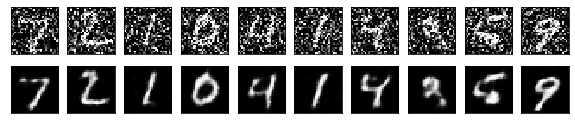

In [191]:
data = iter(test_loader)
images, _ = data.next()

noisy_images = images + noisy_factor*torch.randn(*images.shape)
noisy_images = np.clip(noisy_images, 0., 1.)

output = model(noisy_images)
output = output.view(20, 1, 28, 28)
output = output.detach().numpy()

plt.figure(figsize=(10, 2))
for i in range(10):
    ax = plt.subplot(2, 10, i+1)
    ax.imshow(noisy_images[i].view(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(2, 10, i+1+10)
    ax.imshow(output[i].squeeze(), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)